In [3]:
## setup

# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors

def stylize_plot(axis, xlab, ylab, labelsize=14, ticksize=12, hide=["right","top"], ticks = {"top":False,"bottom":True,"left":True,"right":False}):
        if hide:
                for h in hide:
                        axis.spines[h].set_visible(False)
                        ticks[h] = False

        axis.tick_params(which='minor', length=2, direction="in", top=ticks["top"], bottom=ticks["bottom"], left=ticks["left"], right=ticks["right"], labelsize=ticksize)
        axis.tick_params(which='major', length=4, direction="in", top=ticks["top"], bottom=ticks["bottom"], left=ticks["left"], right=ticks["right"], labelsize=ticksize)

        axis.set_ylabel(ylab,size=labelsize)
        axis.set_xlabel(xlab,size=labelsize)      
        return
    
COLOR_GRADIENT = {"K0,0.1":"xkcd:pale cyan", "K0,0.2":"xkcd:bright sky blue", "K0,0.3":"xkcd:azure", "K0,0.6":"xkcd:azul", "K0,1.0":"xkcd:cobalt blue",
                "K1,0.1":"xkcd:pale gold", "K1,0.2":"xkcd:golden yellow", "K1,0.3":"xkcd:yellowish orange", "K1,0.6":"xkcd:pumpkin orange", "K1,1.0":"xkcd:dark orange",
                "K2,0.1":"xkcd:rosa", "K2,0.2":"xkcd:warm pink", "K2,0.3":"xkcd:dark hot pink", "K2,0.6":"xkcd:dark magenta", "K2,1.0":"xkcd:merlot",
                "K5,0.1":"xkcd:seafoam", "K5,0.2":"xkcd:seaweed", "K5,0.3":"xkcd:seaweed green", "K5,0.6":"xkcd:dark sea green", "K5,1.0":"xkcd:spruce",
                "50,0.3":"xkcd:silver", "50,0.6":"xkcd:gray", "50,1.0":"xkcd:black",
                "100,0.3":"xkcd:butteryellow", "100,0.6":"xkcd:butterscotch", "100,1.0":"xkcd:caramel",
                "300,0.3":"xkcd:lavender", "300,0.6":"xkcd:plum", "300,1.0":"xkcd:plum"}

# load Roboto-Regular to set as font
from matplotlib import font_manager
path_font = [ f for f in font_manager.findSystemFonts(fontpaths=os.getcwd(), fontext="ttf") if "Roboto-Regular" in f][0]
font = font_manager.FontEntry(fname=str(path_font), name="Roboto-Regular")
font_manager.fontManager.ttflist.append(font)

# define font sizes
SIZE_DEFAULT = 10
SIZE_LARGE = 12
plt.rc("font", family=font.name)  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

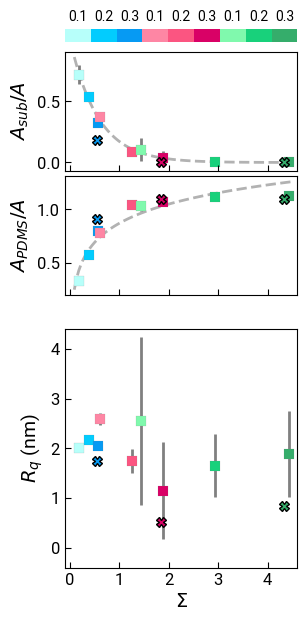

In [ ]:
#Fig 2

def load_data_MC(ROOT, NREP, SOLV, A, A_BIG):
    AREAS = pd.read_csv(f"{ROOT}/surface_area/surface_area_{NREP}.csv")
    THICK = pd.read_csv(f"{ROOT}/thickness/mean_thickness_{NREP}_{SOLV}.csv")
    ROUGHNESS = pd.read_csv(f"{ROOT}/roughness/Rq_{NREP}_{SOLV}.csv")

    AREAS_BIG = pd.read_csv(f"{ROOT}/surface_area/big_surface_area_{NREP}.csv")
    THICK_BIG = pd.read_csv(f"{ROOT}/thickness/big_mean_thickness_{NREP}_vacuum.csv")
    ROUGHNESS_BIG = pd.read_csv(f"{ROOT}/roughness/Rq_{NREP}_vacuum.csv")

    SIG = pd.read_csv(f"{ROOT}/roughness/sigma_{NREP}_{SOLV}_method2.csv")
    SIG_BIG = pd.read_csv(f"{ROOT}/roughness/sigma_{NREP}_vacuum_method2.csv")

    df = SIG.merge(AREAS, on=["dens","run"])
    df_big = SIG_BIG.merge(AREAS_BIG, on=["dens","run"])

    df = df.merge(THICK, on=["dens","run"])
    df_big = df_big.merge(THICK_BIG, on=["dens","run"])

    df = df.merge(ROUGHNESS, on=["dens","run"])
    df_big = df_big.merge(ROUGHNESS_BIG, on=["dens","run"])

    PROJ = (A - AREAS['area_sub'])/A
    PROJ_BIG = (A_BIG - AREAS['area_sub'])/A_BIG

    df["Rscore"] = 1/2 * AREAS["area_sub"]/A * np.abs( (np.cos(CAs["PDMS"]* np.pi/180) - np.cos(CAs["Bare"]* np.pi/180)) ) + 1/2 * (AREAS["area_PDMS"]/A-PROJ) * np.abs((np.cos(CAs["PDMS"]* np.pi/180)))
    df_big["Rscore"] = 1/2 * AREAS_BIG["area_sub"]/A_BIG * np.abs( (np.cos(CAs["PDMS"]* np.pi/180) - np.cos(CAs["Bare"]* np.pi/180)) ) + 1/2 * (AREAS_BIG["area_PDMS"]/A_BIG-PROJ_BIG) * np.abs((np.cos(CAs["PDMS"]* np.pi/180)))
    
    return df, df_big

def power_law_func(x, a, b, c):
    return a * np.power(x, b) + c

def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

ROOT = os.getcwd()
SOLV = "water"
SAMPLES = ["P1","P2","P3"]
SAMPLE = {"K0":"P1","K2":"P2","K5":"P3"}
NREPS = ["K0","K2","K5"]
DENS = [0.1,0.2,0.3]
CAs = {"Bare":75, "PDMS":105, "std_BARE":1, "std_PDMS":2}
df_A = pd.read_csv(f"{ROOT}/surface_area/surface_area_K5.csv")
A = df_A[df_A["run"]=="run1"]["base_area"].max()
df_AB = pd.read_csv(f"{ROOT}/surface_area/big_surface_area_K5.csv")
A_BIG = df_AB[df_AB["run"]=="run4"]["base_area"].max()

#Colorbar
colors = [COLOR_GRADIENT[f"{NREP},{DEN}"] for NREP in NREPS for DEN in DENS]
labels = [f"{DEN}" for SAMPLE in SAMPLES for DEN in DENS]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(colors)+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig,ax = plt.subplots(5,1, figsize=(3,7), sharex=True, gridspec_kw={'height_ratios':[0.15,1,1,0.2,2]})
ax[3].set_axis_off()

data_sub, data_pdms = [],[]
for NREP in NREPS:
    df, df_big = load_data_MC(ROOT, NREP, "water", A, A_BIG)

    df = df[df["dens"].isin(DENS)]
    grouped = df.groupby("dens")

    df_big = df_big[df_big["dens"].isin(DENS)]
    df_big = df_big[df_big["dens"] == 0.3]

    #A_sub/A  
    ax[1].errorbar(df_big["sigma"], df_big["area_sub"]/A_BIG, lw=2, ls="none", marker='X', mec="k", mew=1, mfc=COLOR_GRADIENT[f"{NREP},0.3"], color="gray", ms=7, zorder=3)

    #A_PDMS/A
    ax[2].errorbar(df_big["sigma"], df_big["area_PDMS"]/A_BIG, lw=2, ls="none", marker='X', mec="k", mew=1, mfc=COLOR_GRADIENT[f"{NREP},0.3"], color="gray", ms=7, zorder=3)

    #Roughness
    ax[4].errorbar(df_big["sigma"], df_big["Rq"], marker="X", mec="k", color="gray", mfc=COLOR_GRADIENT[f'{NREP},0.3'], ms=7, mew=1, lw=2, ls="none", zorder=3)


    for  DEN, group in grouped:

        Rq = group["Rq"].mean()
        std = group["Rq"].std()
        sigma = group["sigma"].mean()
        std_sigma = group["sigma"].std()
        
        #A_sub/A
        ax[1].errorbar(group["sigma"].mean(), group["area_sub"].mean()/A, yerr=group["area_sub"].std()/A, lw=2, ls="none", marker='s', mec="gray", mew=0.1, mfc=COLOR_GRADIENT[f"{NREP},{DEN}"], color="gray", label=f"{NREP}, {DEN}", ms=7, zorder=0)

        #A_PDMS/A
        ax[2].errorbar(group["sigma"].mean(), group["area_PDMS"].mean()/A, yerr=group["area_PDMS"].std()/A, lw=2, ls="none", marker='s', mec="gray", mew=0.1, mfc=COLOR_GRADIENT[f"{NREP},{DEN}"], color="gray", label=f"{NREP}, {DEN}", ms=7, zorder=0)

        #Roughness
        ax[4].errorbar(sigma, Rq, xerr=std_sigma, yerr=std, marker="s", mec="gray", color="gray", mfc=COLOR_GRADIENT[f'{NREP},{DEN}'], ms=7, mew=0.1, lw=2, ls="none", zorder=0)

        data_sub.append([group["sigma"].mean(), group["area_sub"].mean()/A])
        data_pdms.append([group["sigma"].mean(), group["area_PDMS"].mean()/A])


data_sub = np.array(data_sub)
popt_exp, pcov_exp = curve_fit(exp_func, data_sub[:,0], data_sub[:,1])
a_exp, b_exp, c_exp = popt_exp
x_sub = np.linspace(data_sub[:,0].min()-0.1,data_sub[:,0].max()+0.1,100)
ax[1].plot(x_sub, exp_func(x_sub, *popt_exp), c="k", ls="dashed", alpha=0.3, lw=2, zorder=-1)

data_pdms = np.array(data_pdms)
popt_log, pcov_log = curve_fit(power_law_func, data_pdms[:,0], data_pdms[:,1], p0=[0,-0.0001,0.0001])
a_log, b_log, c_log = popt_log
x_pdms = np.linspace(data_pdms[:,0].min()-0.1,data_pdms[:,0].max()+0.1,100)
ax[2].plot(x_pdms, power_law_func(x_pdms, *popt_log), c="k", ls="dashed", alpha=0.3, lw=2, zorder=-1)

stylize_plot(ax[1],"","$A_{sub}/A$", hide=False)
stylize_plot(ax[2],"","$A_{PDMS}/A$", hide=False)
stylize_plot(ax[4],"$\\Sigma$","$R_q$ (nm)", hide=False)

ax[0].set_axis_off()
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('top', size="90%", pad=-0.1)
cbar = fig.colorbar(sm, ax=ax[0], cax=cax, orientation='horizontal', location='top', shrink=0.8, ticks=np.arange(len(colors))+0.5)
cbar.ax.set_xticklabels(labels, ha='center')
cbar.ax.tick_params(which='both', size=0)
cbar.outline.set_edgecolor('none')

ax[4].set_yticks([0,1,2,3,4])
ax[4].set_ylim(-0.4,4.4)
ax[4].set_xlim(-0.1,4.6)
ax[4].set_xticks([0,1,2,3,4])

fig.subplots_adjust(wspace=0.4, hspace=0.05)
fig.savefig(f"{ROOT}/plots/Fig1_pt2.png", dpi=400, bbox_inches="tight")
fig.savefig(f"{ROOT}/plots/Fig1_pt2.svg", dpi=400, bbox_inches="tight")

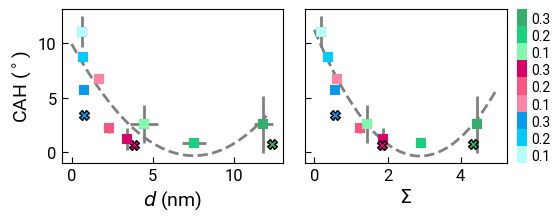

In [9]:
# Fig 3


def load_data_MC(ROOT, NREP, SOLV):
    df_A = pd.read_csv(f"{ROOT}/surface_area/surface_area_K5.csv")
    A = df_A[df_A["run"]=="run1"]["base_area"].max()
    df_AB = pd.read_csv(f"{ROOT}/surface_area/big_surface_area_K5.csv")
    A_BIG = df_AB[df_AB["run"]=="run4"]["base_area"].max()
    
    AREAS = pd.read_csv(f"{ROOT}/surface_area/surface_area_{NREP}.csv")
    AREAS_BIG = pd.read_csv(f"{ROOT}/surface_area/big_surface_area_{NREP}.csv")

    SIG = pd.read_csv(f"{ROOT}/roughness/sigma_{NREP}_{SOLV}_method2.csv")
    SIG_BIG = pd.read_csv(f"{ROOT}/roughness/sigma_{NREP}_vacuum_method2.csv")

    THICK = pd.read_csv(f"{ROOT}/thickness/mean_thickness_{NREP}_{SOLV}.csv")
    THICK_BIG = pd.read_csv(f"{ROOT}/thickness/big_mean_thickness_{NREP}_vacuum.csv")

    PROJ = (A - AREAS['area_sub'])/A
    PROJ_BIG = (A_BIG - AREAS_BIG['area_sub'])/A_BIG

    df_rough = SIG.merge(THICK, on=["dens","run"])
    df_rough_big = SIG_BIG.merge(THICK_BIG, on=["dens","run"])
    df_rough["Rscore"] = 1/2 * AREAS["area_sub"]/A * np.abs( (np.cos(CAs["PDMS"]* np.pi/180) - np.cos(CAs["Bare"]* np.pi/180)) ) + 1/2 * (AREAS["area_PDMS"]/A - PROJ) * np.abs((np.cos(CAs["PDMS"]* np.pi/180)))
    df_rough_big["Rscore"] = 1/2 * AREAS_BIG["area_sub"]/A_BIG * np.abs( (np.cos(CAs["PDMS"]* np.pi/180) - np.cos(CAs["Bare"]* np.pi/180)) ) + 1/2 * (AREAS_BIG["area_PDMS"]/A_BIG - PROJ_BIG) * np.abs((np.cos(CAs["PDMS"]* np.pi/180)))
    
    return df_rough, df_rough_big

SAMPLES = ["P1","P2","P3"]
SAMPLE = {"K0":"P1","K2":"P2","K5":"P3"}
NREPS = ["K0","K2","K5"]
DENS = [0.1,0.2,0.3]

# Create a colormap from the colors
colors = [COLOR_GRADIENT[f"{NREP},{DEN}"] for NREP in NREPS for DEN in DENS]
labels = [f"{DEN}" for SAMPLE in SAMPLES for DEN in DENS]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(colors)+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Define the quadratic function
def quadratic_function(x, a, b, c):
    return a * x**2 + b * x + c

ROOT = os.getcwd()
RUNS = ["run1","run2","run3"]
SOLV = "water"
CAs = {"Bare":75, "PDMS":105, "std_BARE":1, "std_PDMS":2}

fig,axes= plt.subplots(1,2, figsize=(6,2), sharey=True)

rscores, sigmas, thicks = [], [], []


for NREP in NREPS:

    df_rough, df_rough_big = load_data_MC(ROOT, NREP, SOLV)

    for DEN in DENS:

        dfp_big = df_rough_big[df_rough_big["dens"]==DEN]
        axes[0].errorbar(dfp_big["thickness"]*0.1,  dfp_big["Rscore"]*180/np.pi, lw=2, ls="none", marker='X', mew=1, mec="k", mfc=COLOR_GRADIENT[f"{NREP},{DEN}"], color="gray", label=f"{SAMPLE[NREP]}, {DEN}", ms=7, zorder=0)
        axes[1].errorbar(dfp_big["sigma"],  dfp_big["Rscore"]*180/np.pi, lw=2, ls="none", marker='X', mew=1, mec="k", mfc=COLOR_GRADIENT[f"{NREP},{DEN}"], color="gray", label=f"{SAMPLE[NREP]}, {DEN}", ms=7, zorder=3)

        dfp = df_rough[df_rough["dens"]==DEN]
        dfmean = dfp[["dens","thickness","sigma","Rscore"]].groupby("dens")

        axes[0].errorbar(dfmean["thickness"].mean()*0.1,  dfmean["Rscore"].mean()*180/np.pi, yerr=dfmean["Rscore"].std()*180/np.pi, 
            xerr=dfmean["thickness"].std()*0.1, lw=2, ls="none", marker='s', mew=0.1, mec="gray", mfc=COLOR_GRADIENT[f"{NREP},{DEN}"], color="gray", label=f"{SAMPLE[NREP]}, {DEN}", ms=7, zorder=0)
        axes[1].errorbar(dfmean["sigma"].mean(),  dfmean["Rscore"].mean()*180/np.pi, yerr=dfmean["Rscore"].std()*180/np.pi, 
            xerr=dfmean["sigma"].std(), lw=2, ls="none", marker='s', mew=0.1, mec="gray", mfc=COLOR_GRADIENT[f"{NREP},{DEN}"], color="gray", label=f"{SAMPLE[NREP]}, {DEN}", ms=7, zorder=0)


        sigmas.extend(dfmean["sigma"].mean())
        thicks.extend(dfmean["thickness"].mean()*0.1)
        rscores.extend(dfmean["Rscore"].mean()*180/np.pi)  


# Fit the polynomial to the data thickness
variables = np.array(thicks)
rscores = np.array(rscores)
coefficients = np.polyfit(variables, rscores, 2)

# Generate points for plotting the fitted curve
x_fit = np.linspace(0, 12, 500)
y_fit = np.polyval(coefficients, x_fit)
axes[0].plot(x_fit, y_fit, ls="--", color="gray", lw=2, zorder=-1)

stylize_plot(axes[0],f"$d$ (nm)",r"CAH ($^\circ$)", hide=False)

# Fit the polynomial to the data sigma
variables = np.array(sigmas)
rscores = np.array(rscores)
coefficients = np.polyfit(variables, rscores, 2)

# Generate points for plotting the fitted curve
x_fit = np.linspace(0, 5, 500)
y_fit = np.polyval(coefficients, x_fit)
axes[1].plot(x_fit, y_fit, ls="--", color="gray", lw=2, zorder=-1)

stylize_plot(axes[1],"$\\Sigma$",r"", hide=False)

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size="5%", pad=0.1)
cbar = fig.colorbar(sm, ax=axes[1], cax=cax, orientation='vertical', shrink=0.8, ticks=np.arange(len(colors))+0.5)
cbar.ax.set_yticklabels(labels, ha='left')
cbar.ax.tick_params(which='both', size=0)
cbar.outline.set_edgecolor('none')

fig.subplots_adjust(wspace=0.1)

fig.savefig(f"{ROOT}/plots/CAH_thick_{SOLV}.svg", dpi=400, bbox_inches="tight")
fig.savefig(f"{ROOT}/plots/CAH_thick_{SOLV}.png", dpi=400, bbox_inches="tight")